# 更多激活函数

在上一个章节，我们通过引入丢弃层，添加“白噪音”，来解决网络模型”过度关注细节“造成的过拟合问题。

现在，让我们讨论一下照片”曝光过度"带来的极端数值可能带来的**梯度爆炸**（Exploding Gradient）、或者**梯度消失**（Vanishing Gradient）问题。

还记得我们在 MNIST 数据集中，通过**归一化**将所有像素数据从 (0, 255) 的整数转换成 (0, 1) 的小数吗？主要原因就是过大的特征值在经过层层累积放大后，会导致梯度指数级“爆表”或者“归零”。通过归一化可以有效地解决这个问题。

但是数值过大的问题不止会发生在输入层，各层产生的中间值也可能有同样的问题。这时候我们可以通过引入更多类型的激活函数层来应对不同的数据问题。

---

我们已经使用过 ReLU 激活函数，通过“负数归零”的办法，来消除噪音、无效数据。

其他最常用的激活函数还有：

* **Tanh 激活函数**：它可以将任何数值映射到 (-1, 1) 的范围内，同时保持数值之间的相对关系。可以用来消除“曝光过度”造成的极端数值，使数据分布在零点附近。和 ReLU 激活函数一样，常用于中间隐藏层。
* **Sigmoid 激活函数**：它可以把任何数值平滑地压缩到 (0, 1) 的范围之间。因此可以解释为某个事件发生的概率，常用于二元分类问题的输出层，来规范预测结果。
* **Softmax 激活函数**：它用于一组数值的情况，将它们转换为相互之间的相对比例，并维持总和为 1。因此常用于多元分类问题的输出层，数值最大的那个选项就是预测结果。

In [29]:
import matplotlib.pyplot as plt
from abc import abstractmethod, ABC
import numpy as np

np.random.seed(99)

## 基础架构

### 张量

In [30]:
class Tensor:

    def __init__(self, data):
        self.data = np.array(data)
        self.grad = np.zeros_like(self.data)
        self.gradient_fn = lambda: None
        self.parents = set()

    def backward(self):
        if self.gradient_fn:
            self.gradient_fn()

        for p in self.parents:
            p.backward()

    @property
    def size(self):
        return np.prod(self.data.shape[1:])

    def __repr__(self):
        return f'Tensor({self.data})'

### 基础数据集

In [31]:
class Dataset(ABC):

    def __init__(self, batch_size=1):
        self.batch_size = batch_size
        self.load()
        self.train()

    @abstractmethod
    def load(self):
        pass

    def train(self):
        self.features = self.train_features
        self.labels = self.train_labels

    def eval(self):
        self.features = self.test_features
        self.labels = self.test_labels

    def shape(self):
        return Tensor(self.features).size, Tensor(self.labels).size

    def items(self):
        return Tensor(self.features), Tensor(self.labels)

    def __len__(self):
        return len(self.features) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size

        feature = Tensor(self.features[start: end])
        label = Tensor(self.labels[start: end])
        return feature, label

    def estimate(self, predictions):
        pass

### 基础层

In [32]:
class Layer(ABC):

    def __init__(self):
        self.training = True

    def __call__(self, x: Tensor):
        return self.forward(x)

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    @abstractmethod
    def forward(self, x: Tensor):
        pass

    @property
    def parameters(self):
        return []

    def __repr__(self):
        return ''

### 基础损失函数

In [33]:
class Loss(ABC):

    def __call__(self, p: Tensor, y: Tensor):
        return self.loss(p, y)

    @abstractmethod
    def loss(self, p: Tensor, y: Tensor):
        pass

### 基础优化器

In [34]:
class Optimizer(ABC):

    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr

    def reset(self):
        for p in self.parameters:
            p.grad = np.zeros_like(p.data)

    @abstractmethod
    def step(self):
        pass

### 基础模型

In [35]:
class Model(ABC):

    def __init__(self, layer, loss_fn, optimizer):
        self.layer = layer
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    @abstractmethod
    def train(self, dataset, epochs):
        pass

    @abstractmethod
    def test(self, dataset):
        pass

## 数据

### MNIST 数据集

In [36]:
class MNISTDataset(Dataset):

    def __init__(self, filename, batch_size=1):
        self.filename = filename
        super().__init__(batch_size)

    def load(self):
        with (np.load(self.filename, allow_pickle=True) as f):
            self.train_features, self.train_labels = self.normalize(f['x_train'], f['y_train'])
            self.test_features, self.test_labels = self.normalize(f['x_test'], f['y_test'])

    @staticmethod
    def normalize(x, y):
        inputs = x / 255
        inputs = np.expand_dims(inputs, axis=1)
        targets = np.zeros((len(y), 10))
        targets[range(len(y)), y] = 1
        return inputs, targets

    def estimate(self, predictions):
        count = (predictions.data.argmax(axis=1) == self.labels.argmax(axis=1)).sum()
        total = len(self.labels)
        return count / total

## 模型

### 线性层

In [37]:
class Linear(Layer):

    def __init__(self, in_size, out_size):
        super().__init__()
        self.weight = Tensor(np.random.rand(out_size, in_size) / in_size)
        self.bias = Tensor(np.random.rand(out_size))

    def forward(self, x: Tensor):
        p = Tensor(x.data @ self.weight.data.T + self.bias.data)

        def gradient_fn():
            self.weight.grad += p.grad.T @ x.data
            self.bias.grad += np.sum(p.grad, axis=0)
            x.grad += p.grad @ self.weight.data

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    @property
    def parameters(self):
        return [self.weight, self.bias]

    def __repr__(self):
        return f'Linear[weight{self.weight.data.shape}; bias{self.bias.data.shape}]'

### 顺序层

In [38]:
class Sequential(Layer):

    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def train(self):
        for l in self.layers:
            l.train()

    def eval(self):
        for l in self.layers:
            l.eval()

    def forward(self, x: Tensor):
        for l in self.layers:
            x = l(x)
        return x

    @property
    def parameters(self):
        return [p for l in self.layers for p in l.parameters]

    def __repr__(self):
        return '\n'.join(str(l) for l in self.layers if str(l))

### 展平层

In [39]:
class Flatten(Layer):

    def forward(self, x: Tensor):
        p = Tensor(np.array(x.data.reshape(x.data.shape[0], -1)))

        def gradient_fn():
            x.grad += p.grad.reshape(x.data.shape)

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'Flatten[]'

### 丢弃层

In [40]:
class Dropout(Layer):

    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate

    def forward(self, x: Tensor):
        if not self.training:
            return x

        mask = np.random.random(x.data.shape) > self.dropout_rate
        p = Tensor(x.data * mask)

        def gradient_fn():
            x.grad += p.grad * mask

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'Dropout[rate={self.dropout_rate}]'

### ReLU 激活函数

**前向传播**：负数清零。
$$
y = \text{ReLU}(x) = \max(0, x)
$$

**梯度计算**：正数保留梯度。ReLU 激活函数的导数为：
$$
\frac{dy}{dx} = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}
$$

**父节点列表**（parents）：输入值。

**参数列表**（parameters）：无。

In [41]:
class ReLU(Layer):

    def forward(self, x: Tensor):
        p = Tensor(np.maximum(0, x.data))

        def gradient_fn():
            x.grad += p.grad * (p.data > 0)

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'ReLU[]'

我们看一下 ReLU 激活函数的效果：

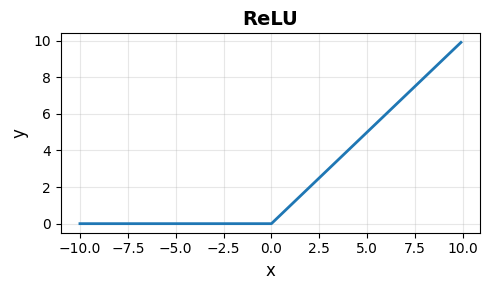

In [42]:
relu = ReLU()
x_range = np.arange(-10, 10, 0.1)
plt.figure(figsize=(5, 3))
plt.plot(x_range, [relu(Tensor(x)).data for x in x_range], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('ReLU', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Tanh 激活函数

**前向传播**：双曲正切，将输入值映射到 (-1, 1) 范围内。输出值零中心化（均值为 0）。我们直接调用 NumPy 提供的 tanh 函数来计算。
$$
y = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

**梯度计算**：Tanh 激活函数的导数可以用其自身来表达。这意味着我们不需要重新计算复杂的指数函数。Tanh 激活函数的导数为：
$$
\frac{dy}{dx} = 1 - \tanh^2(x) = 1 - y^2
$$

当输入值很大、或者很小的时候，导数会趋近于0。这就是我们常说的**梯度饱和**（Gradient Saturation）现象。在深层网络中，这会导致传回来的信号越来越弱，最终引发梯度消失。

**父节点列表**（parents）：输入值。

**参数列表**（parameters）：无。

In [43]:
class Tanh(Layer):

    def forward(self, x: Tensor):
        p = Tensor(np.tanh(x.data))

        def gradient_fn():
            x.grad += p.grad * (1 - p.data ** 2)

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'Tanh[]'

我们看一下 Tanh 激活函数的效果：

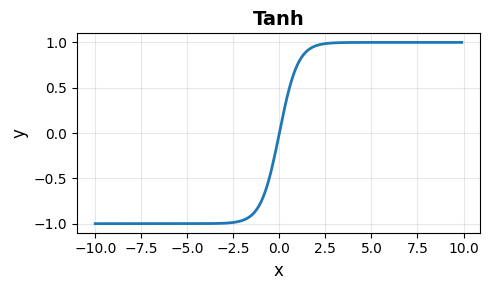

In [44]:
tanh = Tanh()
x_range = np.arange(-10, 10, 0.1)
plt.figure(figsize=(5, 3))
plt.plot(x_range, [tanh(Tensor(x)).data for x in x_range], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Tanh', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Sigmoid 激活函数

**前向传播**：逻辑回归的概率，将任意实数映射到 (0, 1) 区间内。常用于二元分类问题的输出层。
$$
y = \sigma(x) = \frac{1}{1 + e^{-x}}
$$

**梯度计算**：Sigmoid 激活函数的导数也可以用其自身来表达。Sigmoid 激活函数的导数为：
$$
\frac{dy}{dx} = \sigma(x) \cdot (1 - \sigma(x)) = y(1 - y)
$$

Sigmoid 激活函数同样存在梯度饱和的问题。在深层网络中，可能梯度消失。而且，Sigmoid 激活函数还存在梯度衰减的问题。

**父节点列表**（parents）：输入值。

**参数列表**（parameters）：无。

In [45]:
class Sigmoid(Layer):

    def __init__(self, clip_range=(-100, 100)):
        super().__init__()
        self.clip_range = clip_range

    def forward(self, x: Tensor):
        z = np.clip(x.data, self.clip_range[0], self.clip_range[1])
        p = Tensor(1 / (1 + np.exp(-z)))

        def gradient_fn():
            x.grad += p.grad * p.data * (1 - p.data)

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'Sigmoid[]'

我们看一下 Sigmoid 激活函数的效果：

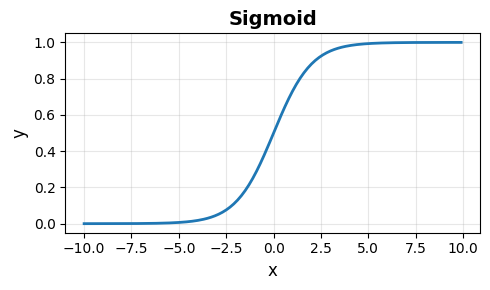

In [46]:
sigmiod = Sigmoid()
x_range = np.arange(-10, 10, 0.1)
plt.figure(figsize=(5, 3))
plt.plot(x_range, [sigmiod(Tensor(x)).data for x in x_range], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Sigmoid', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Softmax 激活函数

**前向传播**：将任意实数向量映射为一个概率分布，使得每个分量位于 (0,1) 区间内，且所有分量之和为 1。常用于多分元分类问题的输出层。
$$
y_i = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$

**梯度计算**：Softmax 激活函数是一个向量函数，其梯度为 Jacobian 矩阵。Softmax 激活函数的导数为：
$$
\frac{dy_i}{dx_i} = g_i - \sum_{j=1}^{n} y_i g_i
$$

**父节点列表**（parents）：输入值。

**参数列表**（parameters）：无。

In [47]:
class Softmax(Layer):

    def __init__(self, axis=-1):
        super().__init__()
        self.axis = axis

    def forward(self, x: Tensor):
        exp = np.exp(x.data - np.max(x.data, axis=self.axis, keepdims=True))
        p = Tensor(exp / np.sum(exp, axis=self.axis, keepdims=True))

        def gradient_fn():
            grad = np.sum(p.data * p.grad, axis=self.axis, keepdims=True)
            x.grad += p.data * (p.grad - grad)

        p.gradient_fn = gradient_fn
        p.parents = {x}
        return p

    def __repr__(self):
        return f'Softmax[]'

我们看一下 Softmax 激活函数的效果：

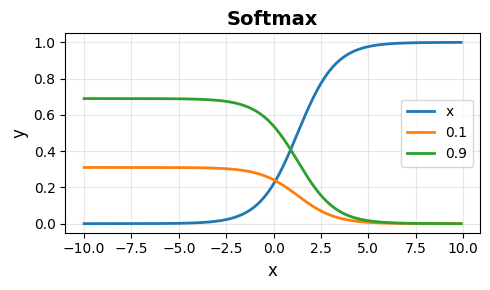

In [48]:
softmax = Softmax()
x_range = np.arange(-10, 10, 0.1)
plt.figure(figsize=(5, 3))
plt.plot(x_range, [softmax(Tensor([x,0.1,0.9])).data for x in x_range], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Softmax', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(['x', '0.1', '0.9'])
plt.show()

Softmax 激活函数是一个向量函数。所以我们可以看到各分量之间相互关系的变化。

### 损失函数（均方误差）

In [ ]:
class MSELoss(Loss):

    def loss(self, p: Tensor, y: Tensor):
        mse = Tensor(np.mean(np.square(y.data - p.data)))

        def gradient_fn():
            p.grad += -2 * (y.data - p.data) / len(y.data)

        mse.gradient_fn = gradient_fn
        mse.parents = {p}
        return mse

### 优化器（随机梯度下降）

In [50]:
class SGDOptimizer(Optimizer):

    def step(self):
        for p in self.parameters:
            p.data -= p.grad * self.lr

### 神经网络模型

In [51]:
class NNModel(Model):

    def train(self, dataset, epochs):
        self.layer.train()
        dataset.train()

        for epoch in range(epochs):
            for i in range(len(dataset)):
                features, labels = dataset[i]

                predictions = self.layer(features)
                loss = self.loss_fn(predictions, labels)
                self.optimizer.reset()
                loss.backward()
                self.optimizer.step()

    def test(self, dataset):
        self.layer.eval()
        dataset.eval()

        features, labels = dataset.items()
        predictions = self.layer(features)
        loss = self.loss_fn(predictions, labels)
        return predictions, loss

## 设置

### 学习率

In [52]:
LEARNING_RATE = 0.01

### 批大小

In [53]:
BATCH_SIZE = 2

### 轮次

In [54]:
EPOCHS = 10

## 训练

### 迭代

MNIST 手写数字识别是一个多元分类问题，所以让我们试一下用 Softmax 激活函数作为输出层激活函数怎么样。

In [55]:
dataset = MNISTDataset('tinymnist.npz', BATCH_SIZE)
layer = Sequential([Flatten(),
                    Linear(dataset.shape()[0], 64),
                    ReLU(),
                    Dropout(),
                    Linear(64, dataset.shape()[1]),
                    Softmax()])
loss_fn = MSELoss()
optimizer = SGDOptimizer(layer.parameters, lr=LEARNING_RATE)

model = NNModel(layer, loss_fn, optimizer)
model.train(dataset, EPOCHS)
print(layer)

Flatten[]
Linear[weight(64, 784); bias(64,)]
ReLU[]
Dropout[rate=0.2]
Linear[weight(10, 64); bias(10,)]
Softmax[]


## 验证

### 测试

In [56]:
predictions, loss = model.test(dataset)
accuracy = dataset.estimate(predictions)
print(f'accuracy: {accuracy:.2%}')

accuracy: 87.30%


使用了Softmax 作为输出层激活函数后，准确率反而下降了一些。怎么回事？

## 总结

| 激活函数 |     主要用途     |                        优点 |                     缺点 |                推荐使用位置 |
|------|:------------:|--------------------------:|-----------------------:|----------------------:|
|ReLU| 默认首选，处理非线性特征 |      计算快；在正区间无梯度饱和，缓解梯度消失 |  负区间梯度为0，可能导致神经元“永久死亡” |              所有的中间隐藏层 |
|Tanh|  处理具有正负值的数据  |     输出零中心化（均值为0），使下一层收敛更快 |      存在梯度饱和；计算涉及指数，开销大 |                   隐藏层 |
|Sigmoid|   二元分类概率预测   | 将输出平滑压缩至(0, 1)区间；输出可解释为概率 | 严重的梯度饱和，导致梯度消失；输出均值不为0 |            二元分类任务的输出层 |
|Softmax|   多元分类概率预测   |       处理多个类别的概率，确保概率总和为1 |  计算复杂；受极端数值影响大 | 多元分类任务的输出层 |

## 课后练习

尝试增加隐藏层，调整隐藏层输出特征维度，更换不同的激活函数，看看对训练效果有什么影响？